In [85]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Image_size= 256
Batch_size= 32
Channels= 3
Epochs= 22

In [3]:
# data loading
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "Potatao_dataset",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

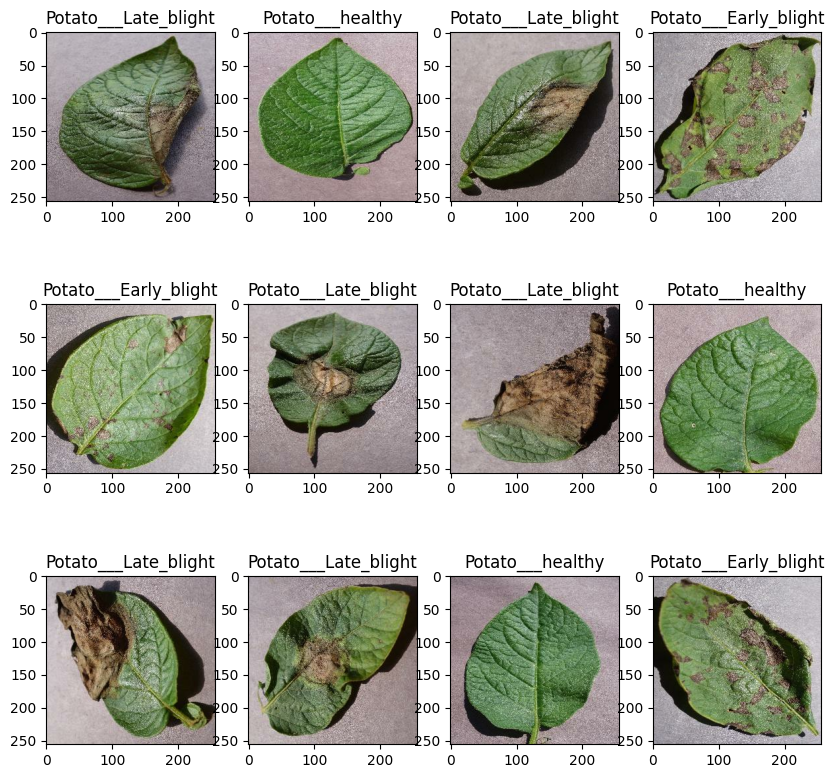

In [5]:
# for visualization
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [6]:
# now we will use 80% in training ,10% in validation ,10% in test
len(dataset)

68

In [7]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True , shuffle_size=10000):

    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
# now we can call our function
train_ds , val_ds , test_ds =get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds) + len(val_ds) + len(test_ds)

68

In [10]:
# caching read the img from disk and when needed it will keep img in the memory
# When you apply prefetch(n) to a dataset, TensorFlow will asynchronously fetch batches of 
# data in the background while the model is executing training steps on the current batch. 
# The n argument specifies how many batches TensorFlow should prefetch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
INPUT_SHAPE= (Batch_size, Image_size, Image_size, Channels)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32, (3,3) , activation='relu' , input_shape= INPUT_SHAPE ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=INPUT_SHAPE)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/22
54/54 [==============================] - 106s 2s/step - loss: 0.8710 - accuracy: 0.5556 - val_loss: 0.8140 - val_accuracy: 0.5625
Epoch 2/22
54/54 [==============================] - 104s 2s/step - loss: 0.5386 - accuracy: 0.7575 - val_loss: 0.4345 - val_accuracy: 0.8281
Epoch 3/22
54/54 [==============================] - 95s 2s/step - loss: 0.3756 - accuracy: 0.8426 - val_loss: 0.2884 - val_accuracy: 0.8750
Epoch 4/22
54/54 [==============================] - 100s 2s/step - loss: 0.2996 - accuracy: 0.8848 - val_loss: 0.3098 - val_accuracy: 0.9062
Epoch 5/22
54/54 [==============================] - 97s 2s/step - loss: 0.2529 - accuracy: 0.9010 - val_loss: 0.1911 - val_accuracy: 0.9271
Epoch 6/22
54/54 [==============================] - 97s 2s/step - loss: 0.2893 - accuracy: 0.8767 - val_loss: 0.3067 - val_accuracy: 0.8646
Epoch 7/22
54/54 [==============================] - 97s 2s/step - loss: 0.1873 - accuracy: 0.9248 - val_loss: 0.1674 - val_accuracy: 0.9375
Epoch 8/22
54/54 

In [17]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 347ms/step - loss: 0.4590 - accuracy: 0.8633


In [18]:
 scores

[0.45898008346557617, 0.86328125]

In [19]:
history.params

{'verbose': 1, 'epochs': 22, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history.history['accuracy']

[0.5555555820465088,
 0.7575231194496155,
 0.8425925970077515,
 0.8848379850387573,
 0.9010416865348816,
 0.8767361044883728,
 0.9247685074806213,
 0.9369212985038757,
 0.9398148059844971,
 0.9658564925193787,
 0.9519675970077515,
 0.9409722089767456,
 0.9716435074806213,
 0.9797453880310059,
 0.9768518805503845,
 0.9751157164573669,
 0.9728009104728699,
 0.9785879850387573,
 0.9803240895271301,
 0.9866898059844971,
 0.9444444179534912,
 0.9780092835426331]

In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [1]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(range(Epochs), acc, label='Training_accuracy')
plt.plot(range(Epochs), val_acc, label='Validation_accuracy')
plt.legend(loc='lower right')
plt.title('Training_accuracy and Validation_accuracy')

plt.subplot(2,1,1)
plt.plot(range(Epochs), loss, label='Loss')
plt.plot(range(Epochs), val_loss, label='Validation_loss')
plt.legend(loc='lower right')
plt.title('loss and Validation_loss')


NameError: name 'plt' is not defined

Image to predict
image actual label: Potato___Early_blight
1/1 [==============================] - 0s 385ms/step
IMAGE PREDICTED LABEL: Potato___Early_blight


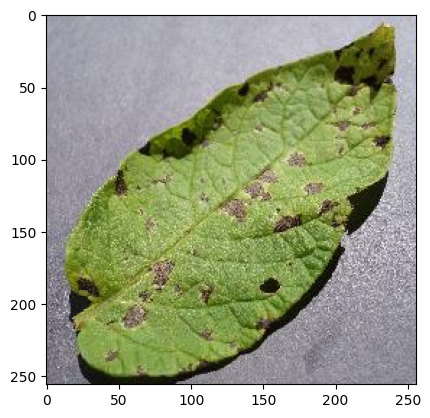

In [94]:
#Now we will make predictions on sample images
for images_batch , label_batch in test_ds.take(1):
    first_img=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print('Image to predict')
    plt.imshow(first_img)
    print('image actual label:' , class_names[first_label])


    batch_prediction=model.predict(images_batch)
    print('IMAGE PREDICTED LABEL:',class_names[np.argmax(batch_prediction[0])])

In [122]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0) #batch

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=100*(np.argmax(predictions[0]))
    return predicted_class , confidence

1/1 [==============================] - 0s 21ms/step


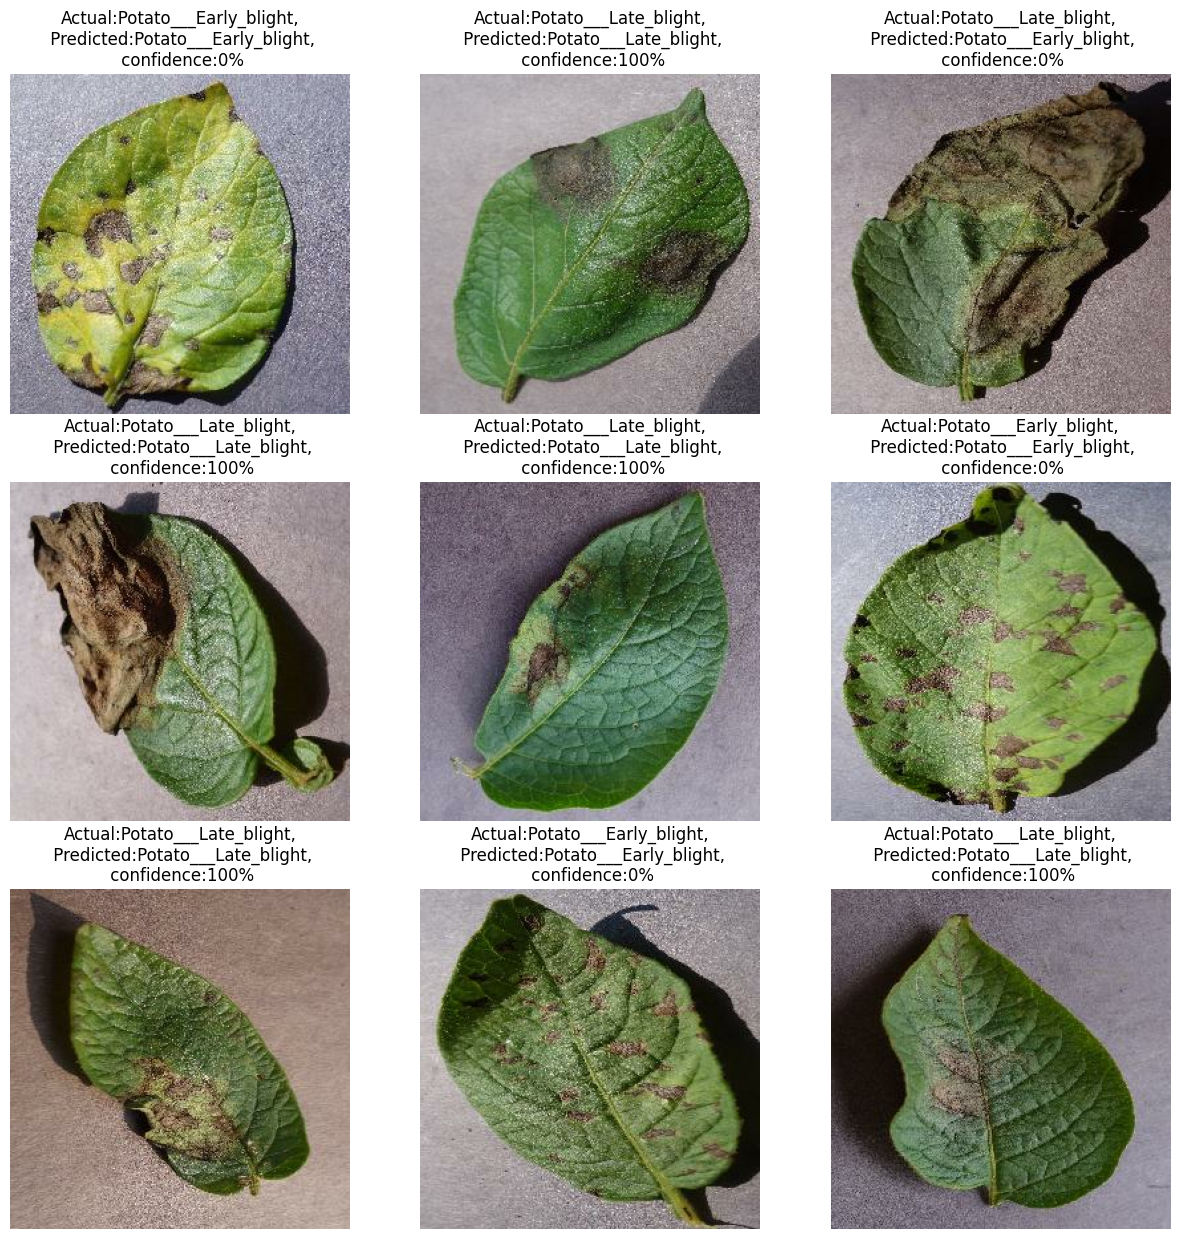

In [123]:
# now lets run prediction on entire batch
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class , confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n confidence:{confidence}%")
        plt.axis('off')

In [124]:
model_version=1.0
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1.0\assets


INFO:tensorflow:Assets written to: ../models/1.0\assets
